In [2]:
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner

fds = FederatedDataset(
    dataset="flwrlabs/caltech101",
    partitioners={"train": IidPartitioner(num_partitions=10)}
)
partition = fds.load_partition(partition_id=0)


c:\Users\Vignesh\Downloads\Multimodal Archive Retrieval\.venv\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Vignesh\.cache\huggingface\hub\datasets--flwrlabs--caltech101. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Generating train split: 100%|██████████| 8677/8677 [00:00<00:00, 29748.20 examples/

IMAGE 

In [7]:
from transformers import CLIPProcessor, CLIPModel
import torch
from datasets import DatasetDict
import random
import matplotlib.pyplot as plt
from datasets import load_from_disk
import faiss
import numpy as np

In [ ]:

dataset = DatasetDict({"train": partition})

print(dataset)
print(f"Number of samples: {len(dataset['train'])}")

# Step 3: Save to disk (so you can reload without redownloading)
save_path = "./caltech101_partition0"
dataset.save_to_disk(save_path)
print(f"Dataset saved to {save_path}")


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 868
    })
})
Number of samples: 868


Saving the dataset (0/1 shards):   0%|          | 0/868 [00:00<?, ? examples/s]


OSError: [Errno 22] Invalid argument: 'c:/Users/Vignesh/Downloads/Multimodal Archive Retrieval/caltech101_partition0/train/data-00000-of-00001.arrow'

In [1]:

# Step 4: Reload later without network
save_path = "./caltech101_partition0"
from datasets import load_from_disk
loaded_dataset = load_from_disk(save_path)

print("Reloaded dataset:", loaded_dataset)
print(f"Number of samples: {len(loaded_dataset['train'])}")

c:\Users\Vignesh\Downloads\Multimodal Archive Retrieval\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Reloaded dataset: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 868
    })
})
Number of samples: 868


In [8]:
split_ds = loaded_dataset['train'].train_test_split(test_size=0.2, seed=42)  # 80/20
train_val_split = split_ds['train'].train_test_split(test_size=0.2, seed=42)  # split train into train/val

dataset = DatasetDict({
    "train": train_val_split['train'],
    "val": train_val_split['test'],
    "test": split_ds['test']
})

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 555
    })
    val: Dataset({
        features: ['image', 'label'],
        num_rows: 139
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 174
    })
})


In [9]:


model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

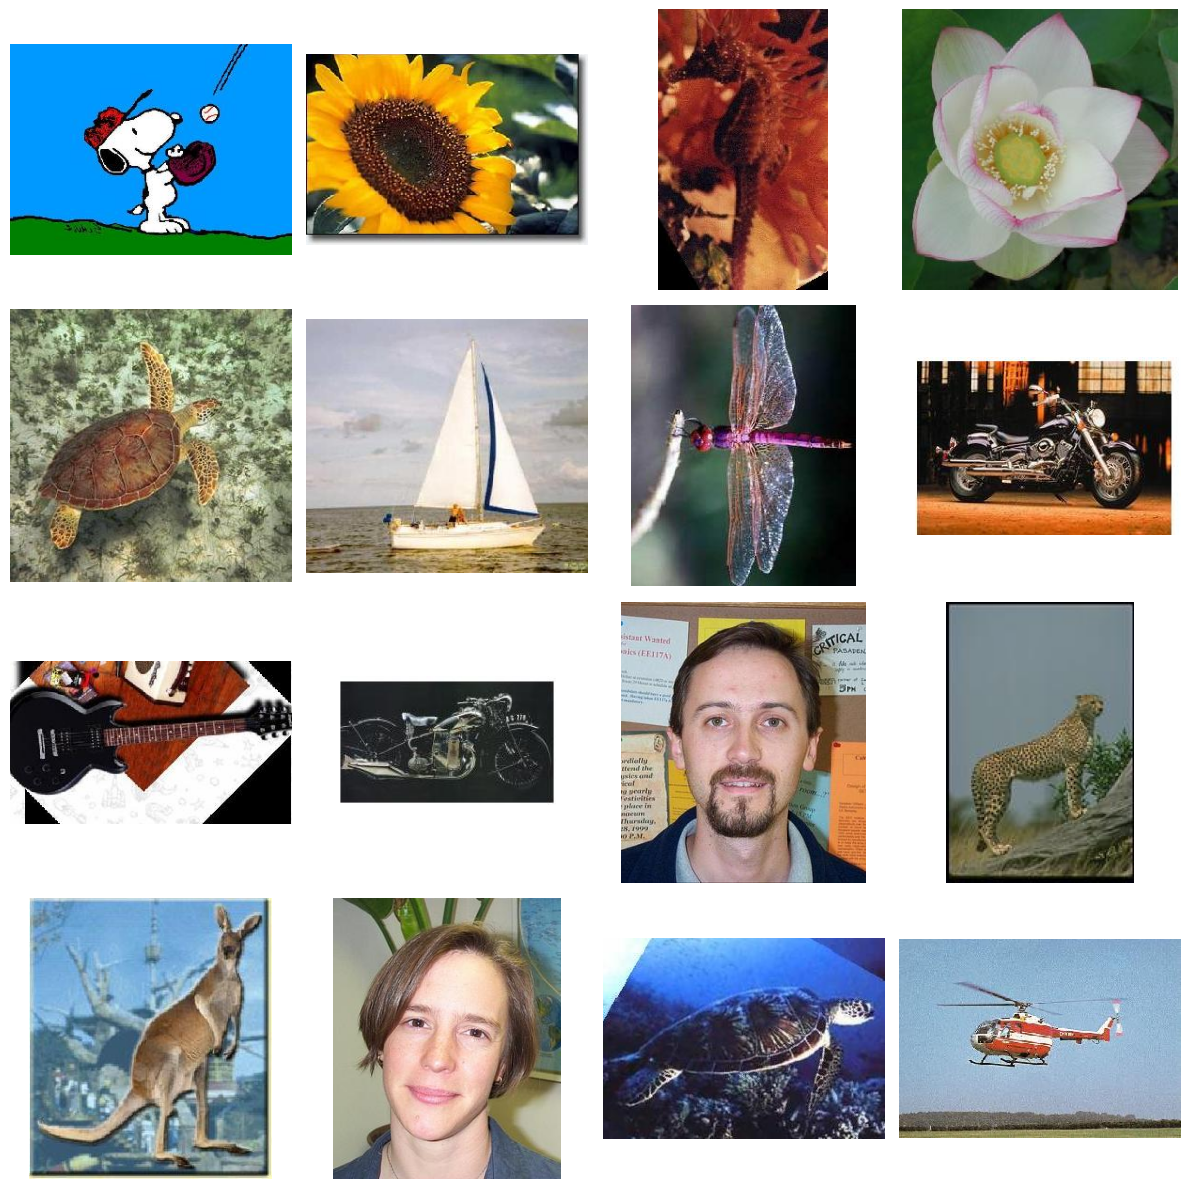

In [10]:


def create_image_collage(dataset, n_images=16, cols=4):
    
    # Get the actual size of the dataset
    dataset_size = len(dataset)
    if n_images > dataset_size:
        print(f"Warning: Requested {n_images} images, but dataset only has {dataset_size}. Showing all available images.")
        n_images = dataset_size
        
    idxs = random.sample(range(dataset_size), n_images)
    images = [dataset[i]["image"] for i in idxs]

    rows = n_images // cols
    if n_images % cols != 0:
        rows += 1
        
    plt.figure(figsize=(cols*3, rows*3))
    
    for i, img in enumerate(images):
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()


create_image_collage(loaded_dataset['train'])


In [11]:
def preprocess_image(example):
    image = example['image']
    inputs = processor(images=image, return_tensors="pt")
    example['pixel_values'] = inputs['pixel_values'].squeeze(0)
    return example

processed_dataset = dataset.map(
    preprocess_image,
    remove_columns=["image"], 
    batched=False
)

processed_dataset.set_format(type="torch", columns=["pixel_values", "label"])
print("Processed dataset:", processed_dataset)

Processed dataset: DatasetDict({
    train: Dataset({
        features: ['label', 'pixel_values'],
        num_rows: 555
    })
    val: Dataset({
        features: ['label', 'pixel_values'],
        num_rows: 139
    })
    test: Dataset({
        features: ['label', 'pixel_values'],
        num_rows: 174
    })
})


In [12]:
label_names = processed_dataset['train'].features['label'].names

# Create a mapping: ID -> class name
id_to_label = {i: name for i, name in enumerate(label_names)}

# Example: print all
for idx, name in id_to_label.items():
    print(f"ID {idx}: {name}")

ID 0: accordion
ID 1: airplanes
ID 2: anchor
ID 3: ant
ID 4: barrel
ID 5: bass
ID 6: beaver
ID 7: binocular
ID 8: bonsai
ID 9: brain
ID 10: brontosaurus
ID 11: buddha
ID 12: butterfly
ID 13: camera
ID 14: cannon
ID 15: car_side
ID 16: ceiling_fan
ID 17: cellphone
ID 18: chair
ID 19: chandelier
ID 20: cougar_body
ID 21: cougar_face
ID 22: crab
ID 23: crayfish
ID 24: crocodile
ID 25: crocodile_head
ID 26: cup
ID 27: dalmatian
ID 28: dollar_bill
ID 29: dolphin
ID 30: dragonfly
ID 31: electric_guitar
ID 32: elephant
ID 33: emu
ID 34: euphonium
ID 35: ewer
ID 36: faces
ID 37: faces_easy
ID 38: ferry
ID 39: flamingo
ID 40: flamingo_head
ID 41: garfield
ID 42: gerenuk
ID 43: gramophone
ID 44: grand_piano
ID 45: hawksbill
ID 46: headphone
ID 47: hedgehog
ID 48: helicopter
ID 49: ibis
ID 50: inline_skate
ID 51: joshua_tree
ID 52: kangaroo
ID 53: ketch
ID 54: lamp
ID 55: laptop
ID 56: leopards
ID 57: llama
ID 58: lobster
ID 59: lotus
ID 60: mandolin
ID 61: mayfly
ID 62: menorah
ID 63: metronome


In [13]:
import numpy as np
def embed_images(dataset_split):
    embeddings = []
    for batch in dataset_split['pixel_values']:
        inputs = batch.unsqueeze(0).to(device)  # add batch dimension
        with torch.no_grad():
            emb = model.get_image_features(inputs)
        emb = emb.cpu().numpy()
        embeddings.append(emb)
    return np.vstack(embeddings)

train_embeddings = embed_images(processed_dataset['train'])
print("Train embeddings shape:", train_embeddings.shape) # e.g., [868, 512] for CLIP ViT-B/32


Train embeddings shape: (555, 512)


In [14]:


d = train_embeddings.shape[1] 
index = faiss.IndexFlatL2(d)   
index.add(train_embeddings)
print("FAISS index size:", index.ntotal)


FAISS index size: 555


In [21]:
def evaluate_retrieval(query_dataset, index_dataset, index, model, processor, k=5, num_queries=100):
    correct_at_k = 0
    total = 0

    for i in range(min(num_queries, len(query_dataset))):  # cap at dataset size
        query_example = query_dataset[i]

        # pixel_values already preprocessed, just turn into tensor
        query_img = torch.tensor(query_example['pixel_values']).unsqueeze(0).to(device)

        with torch.no_grad():
            query_emb = model.get_image_features(query_img).cpu().numpy()

        D, I = index.search(query_emb, k=k)
        retrieved_labels = [index_dataset[int(idx)]['label'] for idx in I[0]]

        if query_example['label'] in retrieved_labels:
            correct_at_k += 1
        total += 1

    accuracy = correct_at_k / total
    return accuracy

# Use val set as queries, train set as database
top5_acc = evaluate_retrieval(
    processed_dataset['val'], 
    processed_dataset['train'], 
    index, model, processor, 
    k=5, num_queries=100
)

print(f"Top-5 Retrieval Accuracy: {top5_acc:.2%}")


C:\Users\Vignesh\AppData\Local\Temp\ipykernel_4664\1425859473.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_img = torch.tensor(query_example['pixel_values']).unsqueeze(0).to(device)


Top-5 Retrieval Accuracy: 92.00%


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def retrieval_confusion_matrix(query_dataset, index_dataset, index, model, processor, k=1, num_queries=200):
    all_labels = sorted(set(query_dataset["label"]) | set(index_dataset["label"]))
    label_to_idx = {label: i for i, label in enumerate(all_labels)}
    matrix = np.zeros((len(all_labels), len(all_labels)), dtype=int)

    for i in range(min(num_queries, len(query_dataset))):
        query_example = query_dataset[i]
        query_img = query_example['pixel_values'].unsqueeze(0).to(device)  # already tensor

        with torch.no_grad():
            query_emb = model.get_image_features(query_img).cpu().numpy()

        D, I = index.search(query_emb, k=k)
        retrieved_labels = [index_dataset[int(idx)]['label'] for idx in I[0]]

        true_label = query_example['label']
        pred_label = retrieved_labels[0]  # top-1

        matrix[label_to_idx[true_label], label_to_idx[pred_label]] += 1

    return matrix, all_labels


# Build confusion matrix on val set
cm, labels = retrieval_confusion_matrix(
    processed_dataset['val'], processed_dataset['train'], 
    index, model, processor, k=1, num_queries=139
)

# Plot
plt.figure(figsize=(10,8))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Retrieved Label (Top-1)")
plt.ylabel("True Query Label")
plt.title("Retrieval Confusion Matrix (Top-1)")
plt.show()


KeyError: tensor(29)

Nearest neighbors (indices): [ 14 106 121  17 352]
Similarity scores (lower = closer): [37.29709  40.047215 45.110554 46.046745 46.146133]


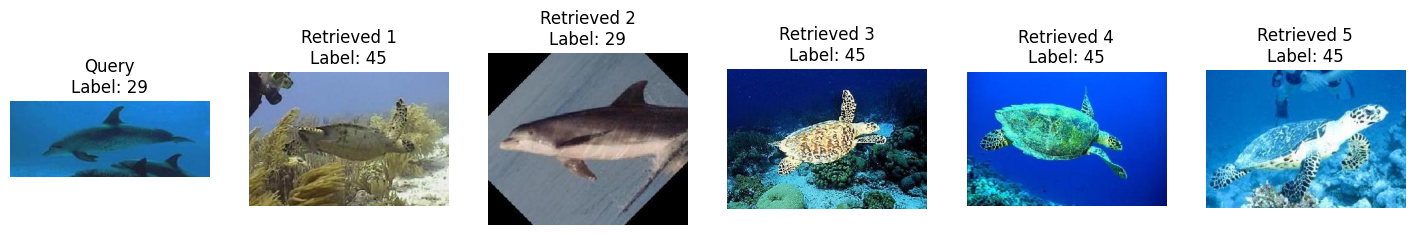

In [ ]:
import matplotlib.pyplot as plt

# pick one query image from validation set
query_example = dataset['val'][0]   # raw example (with image + label)
query_img = processor(images=query_example['image'], return_tensors="pt")["pixel_values"].to(device)

# get embedding
with torch.no_grad():
    query_emb = model.get_image_features(query_img).cpu().numpy()

# search in FAISS index
D, I = index.search(query_emb, k=5)  
print("Nearest neighbors (indices):", I[0])
print("Similarity scores (lower = closer):", D[0])

# plot query and retrieved images
fig, axes = plt.subplots(1, 6, figsize=(18, 5))

# show query image
axes[0].imshow(query_example['image'])
axes[0].set_title(f"Query\nLabel: {query_example['label']}")
axes[0].axis("off")

# show retrieved neighbors
for i, idx in enumerate(I[0]):
    neighbor_example = dataset['train'][int(idx)]   # convert np.int64 -> Python int
    axes[i+1].imshow(neighbor_example['image'])
    axes[i+1].set_title(f"Retrieved {i+1}\nLabel: {neighbor_example['label']}")
    axes[i+1].axis("off")

plt.show()


VIDEO

AUDIO

TEXT